In [ ]:
# Import packages 
import numpy as np
import xarray as xr
from scipy.stats import linregress as _linregress
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import geopandas as gp
import regionmask
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator)

### Load Datasets

In [66]:
# ERA5 700
era5_700 = xr.open_dataset('/scratch/midway3/krucker01/ERA5/era5_q700_monthly_1deg_1980-2023.nc')
era5_700 = era5_700.compute()*1000
era5_700 = era5_700.squeeze().rename({'lat':'latitude', 'lon':'longitude'})

In [67]:
# ERA5 850
era5_850 = xr.open_dataset('/scratch/midway3/krucker01/ERA5/era5_q850_monthly_1deg_1980-2023.nc')
era5_850 = era5_850.compute()*1000
era5_850 = era5_850.squeeze().rename({'lat':'latitude', 'lon':'longitude'})

In [68]:
# AMIP
files = np.sort(glob.glob('/project/tas1/itbaxter/for-tiffany/amip/180x360/hus/*'))
files = np.delete(files, [0,8])
amip = xr.open_mfdataset(files, combine = 'nested', concat_dim = 'member_id').sel(time = slice('1980','2014'))
amip = amip.drop_sel(member_id = ['GISS-E2-2-G_r1i1p3f1', 'GISS-E2-2-G_r2i1p3f1', 'GISS-E2-2-G_r3i1p3f1',
       'GISS-E2-2-G_r4i1p3f1', 'GISS-E2-2-G_r5i1p3f1','E3SM-1-0_r3i1p1f1'])
amip = amip.compute()*1000
amip_700 = amip.rename({'lat':'latitude', 'lon':'longitude'})
amip_700['latitude'] = era5_850['latitude']
amip_700['longitude'] = era5_850['longitude']


In [69]:
files = np.sort(glob.glob('/project2/tas1/itbaxter/for-tiffany/amip/180x360/hus/hus850*'))
amip_850 = xr.open_mfdataset(files, combine = 'nested', concat_dim = 'member_id').sel(time = slice('1980','2014'))
amip_850 = amip_850.rename({'lat':'latitude', 'lon':'longitude'})
amip_850 = amip_850.compute()*1000
amip_850['latitude'] = era5_850['latitude']
amip_850['longitude'] = era5_850['longitude']

In [70]:
# NGCM 700
ngcm_700 = xr.open_dataset('/scratch/midway3/krucker01/ai-models/ngcm/q_700_ngcm_monthly_1981_2023.nc')
ngcm_700 = ngcm_700.compute()*1000

In [71]:
# NGCM 850
ngcm_850 = xr.open_dataset('/scratch/midway3/krucker01/q_850_ngcm_1981_2023.nc')
ngcm_850 = ngcm_850.compute()*1000
ngcm_850 = ngcm_850.to_dataarray()

In [73]:
# ACE2 700
#ace2_700 = xr.open_dataset('/scratch/midway3/krucker01/ai-models/ACE2/ace2_q700_yearly_1979_2023.nc').compute()
ace2_700 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_q700_yearly_1980_2022.nc')
ace2_700 = (ace2_700*1000).rename({'lat':'latitude', 'lon':'longitude'})
ace2_700['latitude'] = era5_700['latitude']
ace2_700['longitude'] = era5_700['longitude']

In [74]:
# ACE2 850
#ace2_850 = xr.open_dataset('/scratch/midway3/krucker01/ai-models/ACE2/ace2_q850_yearly_1979_2023.nc').compute()
ace2_850 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_q850_yearly_1980_2022.nc')
ace2_850 = (ace2_850*1000).rename({'lat':'latitude', 'lon':'longitude'})
ace2_850['latitude'] = era5_850['latitude']
ace2_850['longitude'] = era5_850['longitude']

In [ ]:
# Trend Function 
def linregress(da_y, da_x, dim=None):
    '''xarray-wrapped function of scipy.stats.linregress.
    Note the order of the input arguments x, y is reversed to the original scipy function.'''
    if dim is None:
        dim = [d for d in da_y.dims if d in da_x.dims][0]
    slope, intercept, r, p, stderr = xr.apply_ufunc(_linregress, da_x, da_y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True,
        dask='allowed')
    predicted = da_x * slope + intercept
    slope.attrs['long_name'] = 'slope of the linear regression'
    intercept.attrs['long_name'] = 'intercept of the linear regression'
    r.attrs['long_name'] = 'correlation coefficient'
    p.attrs['long_name'] = 'p-value'
    stderr.attrs['long_name'] = 'standard error of the estimated gradient'
    predicted.attrs['long_name'] = 'predicted values by the linear regression model'
    return xr.Dataset(dict(slope=slope, intercept=intercept,
        r=r, p=p, stderr=stderr, predicted=predicted))

def draw_boxes(lon_min,lon_max,lat_min,lat_max):
    
    box_lon = [lon_min, lon_max, lon_max, lon_min, lon_min]
    box_lat = [lat_min, lat_min, lat_max, lat_max, lat_min]

    # Plot the box using plt.plot (on the same projection)
    ax.plot(box_lon, box_lat, color='k', linestyle='-', linewidth=2, zorder=20, transform=ccrs.PlateCarree())


# Mask function
def maskgen(shpfile, dat4mask, regionname):

    maskcoords = xr.Dataset({'latitude' : (['latitude'],dat4mask['latitude'].values)}, {'longitude' : (['longitude'],dat4mask['longitude'].values)})

    mask = np.zeros([maskcoords.latitude.size, maskcoords.longitude.size])

    shpcontents = gp.read_file(shpfile)

    for i in range(0,len(regionname),1):
        #print('masking '+regionname[i])
        try:
            region = shpcontents[shpcontents.NAME_1 == regionname[i]]

        except:
            region = shpcontents[shpcontents.NAME_0 == regionname[i]]
        maskt = regionmask.mask_geopandas(region, maskcoords['longitude'], maskcoords['latitude'])
        maskt = np.where(np.isnan(maskt), 0, 1)
        mask[:,:] = mask[:,:] + maskt[:,:]

    mask = np.where(mask == 0, np.nan, 1)
    mask = xr.DataArray(mask, coords = maskcoords.coords)

    return mask

# Area weighted average
def area_weighted_ave(ds):
    if 'lat' not in ds.dims:
        ds = ds.rename({'latitude':'lat','longitude':'lon'})
    coslat = np.cos(np.deg2rad(ds.lat))
    ds,coslat = xr.broadcast(ds,coslat)
    ds = ds * coslat
    #return ds.mean(('lat','lon'),skipna=True)
    return ds.sum(('lat','lon'),skipna=True)/((ds/ds)*coslat).sum(('lat','lon'),skipna=True)

def convert_longitude(ds):
    """
    Convert longitude from [0, 360] to [-180, 180].
    
    Parameters:
    - lon: array-like, input longitudes in the range [0, 360]
    
    Returns:
    - Converted longitudes in the range [-180, 180]
    """
    ds_new = ds.copy()
    lon = ds['longitude']  # Convert input to a NumPy array if it's not already
    converted_lon = (lon + 180) % 360 - 180  # Apply conversion
    ds_new.coords['longitude'] = converted_lon
    return ds_new.sortby('longitude')
    
def get_box(ds, lon1, lon2, lat1, lat2):
    ds_con = convert_longitude(ds)
    return area_weighted_ave(ds_con.sel(longitude=slice(lon1, lon2),latitude=slice(lat1, lat2)))

### Masks 

In [79]:
# USA mask
shpfile = "/scratch/midway3/krucker01/shp/gadm36_USA_1.shp"
states = ['California','Nevada','Utah','Arizona','New Mexico','Colorado']

mask_era5 = maskgen(shpfile, era5_700, states)

mask_amip = maskgen(shpfile, amip_700, states)

mask_ngcm = maskgen(shpfile, ngcm_700, states)

mask_ace2 = maskgen(shpfile, ace2_700, states)

masking California
masking Nevada
masking Utah
masking Arizona
masking New Mexico
masking Colorado
masking California
masking Nevada
masking Utah
masking Arizona
masking New Mexico
masking Colorado
masking California
masking Nevada
masking Utah
masking Arizona
masking New Mexico
masking Colorado
masking California
masking Nevada
masking Utah
masking Arizona
masking New Mexico
masking Colorado


In [ ]:
# Land sea mask from ERA5
land_sea_mask = xr.open_dataset('/scratch/midway3/krucker01/shp/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc')

#Regrid mask 1 degree
lat01 = land_sea_mask['latitude']
lon01 = land_sea_mask['longitude']

lat28 = era5_700['latitude']
lon28 = era5_700['longitude']

mask_era5_course = land_sea_mask['LSM'][0].interp(latitude=lat28, longitude=lon28)

ocean_mask = xr.where(mask_era5_course, 1, np.nan)
land_mask = xr.where(mask_era5_course, np.nan, 1)

#Regrid mask 2.8 degree
lat01 = land_sea_mask['latitude']
lon01 = land_sea_mask['longitude']

lat28 = ngcm_700['latitude']
lon28 = ngcm_700['longitude']

mask_era5_course = land_sea_mask['LSM'][0].interp(latitude=lat28, longitude=lon28)

ocean_mask_course = xr.where(mask_era5_course, 1, np.nan)
land_mask_course = xr.where(mask_era5_course, np.nan, 1)


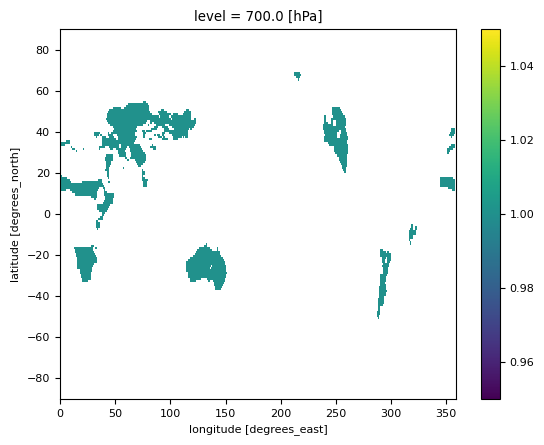

In [83]:
arid_mask = xr.open_dataarray('/scratch/midway2/krucker01/shp/aridity_mask_180x360.nc')

arid_mask = arid_mask.where(arid_mask>0.05).where(arid_mask<0.5)
arid_mask = xr.where(np.isnan(arid_mask),arid_mask, 1)

arid_mask['latitude'] = era5_700['latitude']
arid_mask['longitude'] = era5_700['longitude']

arid_mask.plot()

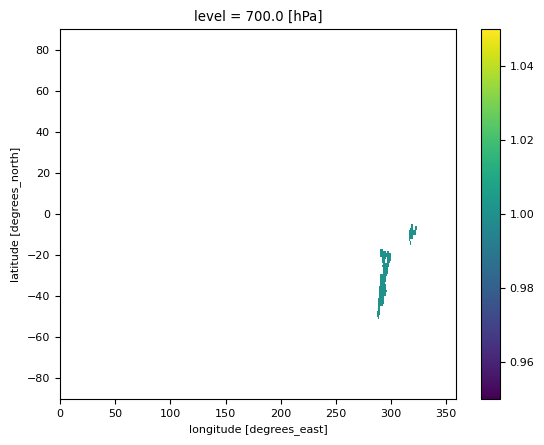

In [ ]:
# Arid mask South America 1 degree
min_lat = -100
max_lat = 45
min_lon = 275
max_lon = 325


mask = (arid_mask.latitude >= min_lat) & (arid_mask.latitude <= max_lat) & (arid_mask.longitude >= min_lon) & (arid_mask.longitude <= max_lon)

arid_mask_SA = arid_mask.where(mask)
#arid_mask_SA.plot()

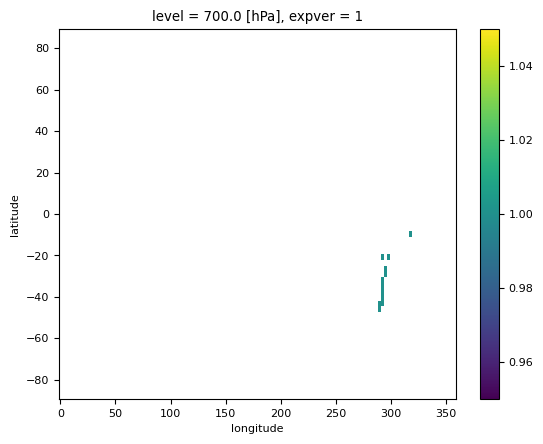

In [ ]:
# South America Mask NGCM
lat01 =arid_mask_SA['latitude']
lon01 = arid_mask_SA['longitude']

lat28 = ngcm_850['latitude']
lon28 = ngcm_850['longitude']

arid_mask_SA_ngcm = arid_mask_SA.interp(latitude=lat28, longitude=lon28)
#arid_mask_SA_ngcm.plot()

### CESM

In [88]:
cesm_700 = amip_700.sel(member_id = ['CESM2_r10i1p1f1', 'CESM2_r1i1p1f1',
       'CESM2_r2i1p1f1', 'CESM2_r3i1p1f1', 'CESM2_r4i1p1f1', 'CESM2_r5i1p1f1',
       'CESM2_r6i1p1f1', 'CESM2_r7i1p1f1', 'CESM2_r8i1p1f1', 'CESM2_r9i1p1f1'])

In [89]:
cesm_850 = amip_850.sel(member_id = ['CESM2_r10i1p1f1', 'CESM2_r1i1p1f1',
       'CESM2_r2i1p1f1', 'CESM2_r3i1p1f1', 'CESM2_r4i1p1f1', 'CESM2_r5i1p1f1',
       'CESM2_r6i1p1f1', 'CESM2_r7i1p1f1', 'CESM2_r8i1p1f1', 'CESM2_r9i1p1f1'])

### Trends

In [90]:
# ERA5 700 Trend
era5_700_lonavg = ((era5_700*ocean_mask).groupby('time.year').mean('time')).sel(year = slice(1981,2014))
era5_700_trend = (linregress(era5_700_lonavg['Q'], era5_700_lonavg['year']).slope)*10

In [91]:
# ERA5 850 Trend
era5_850_lonavg = ((era5_850*ocean_mask).groupby('time.year').mean('time')).sel(year = slice(1981,2014))
era5_850_trend = (linregress(era5_850_lonavg['Q'], era5_850_lonavg['year']).slope)*10

In [92]:
# AMIP 700
amip_700_lonavg = (((amip_700*ocean_mask).groupby('time.year').mean('time')).sel(year = slice(1981,2014)))
amip_700_trend = (linregress(amip_700_lonavg['hus'], amip_700_lonavg['year']).slope)*10

In [93]:
# AMIP 850
amip_850_lonavg = (((amip_850*ocean_mask).groupby('time.year').mean('time')).sel(year = slice(1981,2014)))
amip_850_trend = (linregress(amip_850_lonavg['hus'], amip_850_lonavg['year']).slope)*10

/home/krucker01/.conda/envs/MidwayEnv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [94]:
# CESM 700
cesm_700_lonavg = (((cesm_700*ocean_mask).groupby('time.year').mean('time')).sel(year = slice(1981,2014)))
cesm_700_trend = (linregress(cesm_700_lonavg['hus'], cesm_700_lonavg['year']).slope)*10

In [95]:
# CESM 850
cesm_850_lonavg = (((cesm_850*ocean_mask).groupby('time.year').mean('time')).sel(year = slice(1981,2014)))
cesm_850_trend = (linregress(cesm_850_lonavg['hus'], cesm_850_lonavg['year']).slope)*10

In [96]:
# NGCM 700

ngcm_700_lonavg = (((ngcm_700*ocean_mask_course).groupby('time.year').mean('time')).sel(year = slice(1981,2014)))
ngcm_700_trend = (linregress(ngcm_700_lonavg['__xarray_dataarray_variable__'], ngcm_700_lonavg['year']).slope)*10

In [97]:
# NGCM 850

ngcm_850_lonavg = (((ngcm_850*ocean_mask_course)).sel(year = slice(1981,2014)))
ngcm_850_trend = (linregress(ngcm_850_lonavg, ngcm_850_lonavg['year']).slope)*10

In [98]:
# ACE2 700
ace2_700_lonavg = (ace2_700*ocean_mask).sel(year=slice(1981,2014))
ace2_700_trend = (linregress(ace2_700_lonavg['q700'],ace2_700_lonavg['year']).slope)*10

In [99]:
# ACE2 850
ace2_850_lonavg = (ace2_850*ocean_mask).sel(year=slice(1981,2014))
ace2_850_trend = (linregress(ace2_850_lonavg['q850'],ace2_850_lonavg['year']).slope)*10

### Time series

In [108]:
# SWUS time series 
era5_swu_time = area_weighted_ave((era5_700*ocean_mask).where(mask_era5 == 1)).groupby('time.year').mean('time')
era5_swu_norm = era5_swu_time-(era5_swu_time.sel(year = slice(1980,1990)).mean().Q)

In [109]:
amip_swu_time = area_weighted_ave(((amip_700.mean('member_id')*ocean_mask)).where(mask_amip == 1)).groupby('time.year').mean('time')
amip_swu_norm = amip_swu_time-(amip_swu_time.sel(year=slice(1980,1990)).mean().hus)

In [110]:
ngcm_swu_time = area_weighted_ave(((ngcm_700*ocean_mask_course).mean('member')).where(mask_ngcm == 1)).groupby('time.year').mean('time')
ngcm_swu_norm = ngcm_swu_time-(ngcm_swu_time.sel(year=slice(1980,1990)).mean().__xarray_dataarray_variable__)

In [ ]:
ace2_swu_time = area_weighted_ave((ace2_700*ocean_mask).mean('member_id').where(mask_ace2==1)).sel(year = slice(1981,2021))
ace2_swu_norm = ace2_swu_time-(ace2_swu_time.sel(year=slice(1980,1990)).mean().q700)

In [112]:
# South America Time series
era5_sa_time = area_weighted_ave((era5_700*ocean_mask).where(arid_mask_SA == 1)).groupby('time.year').mean('time')
era5_sa_norm = era5_sa_time-(era5_sa_time.sel(year = slice(1980,1990)).mean().Q)

ngcm_sa_time = area_weighted_ave(((ngcm_700*ocean_mask_course).mean('member')).where(arid_mask_SA_ngcm == 1)).groupby('time.year').mean('time')
ngcm_sa_norm = ngcm_sa_time-(ngcm_sa_time.sel(year=slice(1980,1990)).mean().__xarray_dataarray_variable__)

In [113]:
amip_sa_time = area_weighted_ave(((amip_700.mean('member_id')*ocean_mask)).where(arid_mask_SA == 1)).groupby('time.year').mean('time')
amip_sa_norm = amip_sa_time-(amip_sa_time.sel(year=slice(1980,1990)).mean().hus)

In [ ]:
ace2_sa_time = area_weighted_ave((ace2_700*ocean_mask).mean('member_id').where(arid_mask_SA == 1)).sel(year = slice(1981,2021))
ace2_sa_norm = ace2_sa_time-(ace2_sa_time.sel(year=slice(1980,1990)).mean().q700)

In [ ]:
# Eastern Australia Time series 

min_lat_au = -38
max_lat_au = -26
min_lon_au = 135
max_lon_au = 148

era5_ea_time = get_box(era5_850*ocean_mask,min_lon_au,max_lon_au,min_lat_au,max_lat_au).groupby('time.year').mean('time')
era5_ea_norm = era5_ea_time-(era5_ea_time.sel(year = slice(1980,1990)).mean().Q)

amip_ea_time = get_box((amip_850.mean('member_id')*ocean_mask),min_lon_au,max_lon_au,min_lat_au,max_lat_au).groupby('time.year').mean('time')
amip_ea_norm = amip_ea_time-(amip_ea_time.sel(year=slice(1980,1990)).mean().hus)

ngcm_ea_time = get_box((ngcm_850.mean('variable')*ocean_mask_course),min_lon_au,max_lon_au,min_lat_au,max_lat_au)
ngcm_ea_norm = ngcm_ea_time-(ngcm_ea_time.sel(year=slice(1980,1990)).mean())

ace2_ea_time = get_box(ace2_850.mean('member_id')*ocean_mask,min_lon_au,max_lon_au,min_lat_au,max_lat_au).sel(year = slice(1981,2021))
ace2_ea_norm = ace2_ea_time-(ace2_ea_time.sel(year=slice(1980,1990)).mean().q850)

In [ ]:
colors1 = plt.cm.GnBu(np.linspace(0, 1, 256))
colors2 = plt.cm.YlOrBr(np.linspace(0, 1, 256))[::-1]
new_colors = np.vstack((colors2[:], np.ones((40, 4)), colors1[:]))
new_cmap = LinearSegmentedColormap.from_list('GnBu_YlOrBr', new_colors, N=32)

/home/krucker01/.conda/envs/MidwayEnv/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


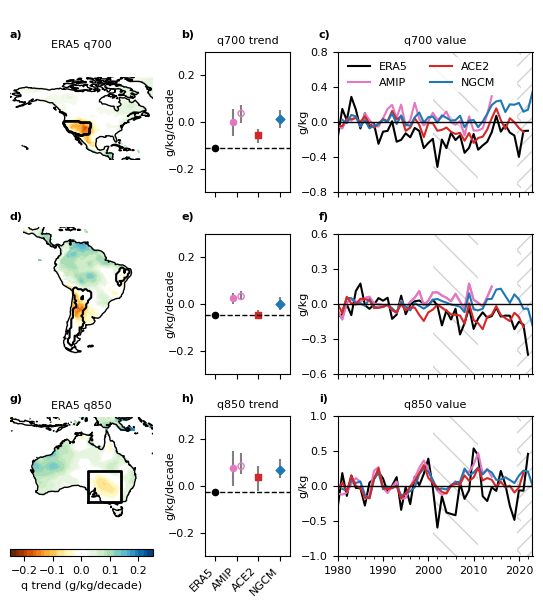

In [ ]:
fig = plt.figure(figsize = (4.75,7))
plt.axis('off')


levels = np.arange(-2.5e-1,2.5001e-1,0.01)
shrink = 0.5
fontsize = 8
ssize = 20
pad = -5
height = 0.2
boxp_width = 0.18
time_width = 0.41
map_width = 0.3
map_height = 0.25
ax = fig.add_axes([0,0.6,map_width,map_height], projection=ccrs.PlateCarree())
plt.rcParams['hatch.color'] = 'lightgray' 

lat = era5_700['latitude']
lon = era5_700['longitude']

lons, lats = np.meshgrid(lon, lat)

# Southwest US
plot = ax.contourf(lons, lats, era5_700_trend, transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels)

plt.contour(mask_era5.longitude, mask_era5.latitude, np.nan_to_num(mask_era5), colors = 'black', linewidths = 2, levels = [0,1])

ax.set_extent([-170,-50,10,80], crs = ccrs.PlateCarree())
ax.xformatter = LongitudeFormatter()
ax.yformatter = LatitudeFormatter()
ax.set_title('ERA5 q700', pad = 21, fontsize = fontsize)
ax.spines[:].set_visible(False)

ax.coastlines()

# Boxplot Southwest US
ax = fig.add_axes([0.41,0.62,boxp_width,height])
ax.scatter([0], area_weighted_ave(era5_700_trend.where(mask_era5 == 1)).values, label = 'ERA5', c = 'k', s = ssize)
amip_swu = area_weighted_ave(amip_700_trend.where(mask_amip == 1)).values
cesm_swu = area_weighted_ave(cesm_700_trend.where(mask_amip == 1)).values
ngcm_swu = area_weighted_ave(ngcm_700_trend.where(mask_ngcm == 1)).values
ace2_swu = area_weighted_ave(ace2_700_trend.where(mask_ace2 == 1)).values


#ngcm_swu = area_weighted_ave(ngcm_trend_850.where(mask_ngcm == 1)).values
ax.scatter([0.8], amip_swu.mean(), color = '#E377C2', marker = 'o', s = ssize)
ax.vlines([0.8], ymin = np.quantile(amip_swu, 0.05), ymax = np.quantile(amip_swu, 0.95), color = 'grey', zorder = -2)
#plt.plot(np.ones(49),amip_swu, 'o')
ax.scatter([1.2], cesm_swu.mean(), edgecolor = '#E377C2', facecolor = 'none', marker = 'o', s = ssize)
ax.vlines([1.2], ymin = np.quantile(cesm_swu, 0.05), ymax = np.quantile(cesm_swu, 0.95), color = 'grey', zorder = -2)
ax.scatter([2], ace2_swu.mean(), c = '#D62728', marker = 's', s = ssize)
ax.vlines([2], ymin = np.quantile(ace2_swu, 0.05), ymax = np.quantile(ace2_swu, 0.95), color = 'grey', zorder = -2)
ax.scatter([3], ngcm_swu.mean(), color = '#1F77B4', marker = 'D', s = ssize)
ax.vlines([3], ymin = np.quantile(ngcm_swu, 0.05), ymax = np.quantile(ngcm_swu, 0.95), color = 'grey', zorder = -2)

ax.set_title('q700 trend', fontsize = fontsize)
ax.axhline(area_weighted_ave(era5_700_trend.where(mask_era5 == 1)).values, color = 'k', linestyle = '--', linewidth = 1)
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_ylim([-0.3,0.3])
ax.set_yticks([-0.2,0,0.2])
ax.set_ylabel('g/kg/decade', fontsize=fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticklabels([])

# Southwest US Time Series
ax = fig.add_axes([0.69,0.62,time_width,height])
ax.plot(era5_swu_norm.year, era5_swu_norm.Q, color = 'k', label = 'ERA5')
ax.plot(amip_swu_norm.year, amip_swu_norm.hus.mean('bnds'), color = '#E377C2', label = 'AMIP')
ax.plot(ace2_swu_norm.year, ace2_swu_norm.q700, color = '#D62728', label = 'ACE2')
ax.plot(ngcm_swu_norm.year, ngcm_swu_norm.__xarray_dataarray_variable__, color = '#1F77B4', label = 'NGCM')

plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

ax.set_title('q700 value', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1980,2023])
ax.set_xticks([1980,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_ylim([-0.8,0.8])
ax.set_yticks([-0.8,-0.4,0,0.4,0.8])
ax.set_ylabel('g/kg', fontsize = fontsize, labelpad = pad)
ax.set_xticklabels([])
ax.tick_params(axis='y', labelsize=fontsize)
ax.legend(bbox_to_anchor = None, loc = 'upper left', edgecolor = 'none', fontsize = fontsize, ncol = 2)

# South America 
ax = fig.add_axes([0,0.38,map_width,map_height-0.06], projection=ccrs.PlateCarree())

plot = ax.contourf(lons, lats, era5_700_trend, transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels)

ax.contour(arid_mask_SA.longitude,arid_mask_SA.latitude,arid_mask_SA.fillna(0),
           colors='k',
           linewidth=2,
           transform=ccrs.PlateCarree(),
           levels = [0,1])

ax.set_extent([-100,-30,-60, 20], crs = ccrs.PlateCarree())
ax.xformatter = LongitudeFormatter()
ax.yformatter = LatitudeFormatter()
ax.coastlines()
ax.spines[:].set_visible(False)

# # South America boxplot
ax = fig.add_axes([0.41,0.36,boxp_width,height])

ax.scatter([0], area_weighted_ave(era5_700_trend.where(arid_mask_SA == 1)).values, label = 'ERA5', c = 'k', s = ssize)
amip_swu = area_weighted_ave(amip_700_trend.where(arid_mask_SA == 1)).values
cesm_swu = area_weighted_ave(cesm_700_trend.where(arid_mask_SA == 1)).values
ngcm_swu = area_weighted_ave(ngcm_700_trend.where(arid_mask_SA_ngcm == 1)).values
ace2_swu = area_weighted_ave(ace2_700_trend.where(arid_mask_SA == 1)).values

ax.scatter([0.8], amip_swu.mean(), color = '#E377C2', marker = 'o', s = ssize)
ax.vlines([0.8], ymin = np.quantile(amip_swu, 0.05), ymax = np.quantile(amip_swu, 0.95), color = 'grey', zorder = -2)
ax.scatter([1.2], cesm_swu.mean(), edgecolor = '#E377C2', facecolor = 'none', marker = 'o', s = ssize)
ax.vlines([1.2], ymin = np.quantile(cesm_swu, 0.05), ymax = np.quantile(cesm_swu, 0.95), color = 'grey', zorder = -2)
ax.scatter([2], ace2_swu.mean(), c = '#D62728', marker = 's', s = ssize)
ax.vlines([2], ymin = np.quantile(ace2_swu, 0.05), ymax = np.quantile(ace2_swu, 0.95), color = 'grey', zorder = -2)
ax.scatter([3], ngcm_swu.mean(), color = '#1F77B4', marker = 'D', s = ssize)
ax.vlines([3], ymin = np.quantile(ngcm_swu, 0.05), ymax = np.quantile(ngcm_swu, 0.95), color = 'grey', zorder = -2)
ax.axhline(area_weighted_ave(era5_700_trend.where(arid_mask_SA == 1)).values, color = 'k', linestyle = '--', linewidth = 1)
ax.set_ylim([-0.3,0.3])
ax.set_yticks([-0.2,0,0.2])
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_ylabel('g/kg/decade', fontsize=fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticklabels([])


#South America Times Series
ax = fig.add_axes([0.69,0.36,time_width,height])
ax.plot(era5_sa_norm.year, era5_sa_norm.Q, color = 'k')#, label = 'ERA5')
ax.plot(amip_sa_norm.year, amip_sa_norm.hus, color = '#E377C2')#, label = 'AMIP')
ax.plot(ngcm_sa_norm.year, ngcm_sa_norm.__xarray_dataarray_variable__, color = '#1F77B4')#, label = 'ACE2')
ax.plot(ace2_sa_norm.year, ace2_sa_norm.q700, color = '#D62728')
plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1980,2023])
ax.set_ylim([-0.6,0.6])
ax.set_yticks([-0.6,-0.3,0,0.3,0.6])
ax.set_xticklabels([])
ax.set_xticks([1980,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_ylabel('g/kg', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='y', labelsize=fontsize)

# Australia
ax = fig.add_axes([0,0.1,map_width,map_height], projection=ccrs.PlateCarree())

plot = ax.contourf(lons, lats, era5_850_trend, transform=ccrs.PlateCarree(),
                   cmap=new_cmap, levels = levels)


ax.set_extent([105,160,-45, -5], crs = ccrs.PlateCarree())
ax.set_title('ERA5 q850', pad = 5.25, fontsize = fontsize)
ax.spines[:].set_visible(False)

draw_boxes(min_lon_au,max_lon_au,min_lat_au,max_lat_au)
ax.xformatter = LongitudeFormatter()
ax.yformatter = LatitudeFormatter()

ax.coastlines()

# Eastern Australia Boxplot
ax = fig.add_axes([0.41,0.1,boxp_width,height])

ax.scatter([0], get_box(era5_850_trend,min_lon_au,max_lon_au,min_lat_au,max_lat_au).values, label = 'ERA5', c = 'k', s = ssize)
amip_ca = get_box(amip_850_trend,min_lon_au,max_lon_au,min_lat_au,max_lat_au).values
cesm_ca = get_box(cesm_850_trend,min_lon_au,max_lon_au,min_lat_au,max_lat_au).values
ngcm_ca = get_box(ngcm_850_trend,min_lon_au,max_lon_au,min_lat_au,max_lat_au).values
ace2_ca = get_box(ace2_850_trend,min_lon_au,max_lon_au,min_lat_au,max_lat_au).values
ax.set_title('q850 trend', fontsize = fontsize)
ax.scatter([0.8], amip_ca.mean(), c = '#E377C2', marker = 'o', s = ssize)
ax.vlines([0.8], ymin = np.quantile(amip_ca, 0.05), ymax = np.quantile(amip_ca, 0.95), color = 'grey', zorder = -2)
ax.scatter([1.2], cesm_ca.mean(), edgecolor = '#E377C2', facecolor = 'none', marker = 'o', s = ssize)
ax.vlines([1.2], ymin = np.quantile(cesm_ca, 0.05), ymax = np.quantile(cesm_ca, 0.95), color = 'grey', zorder = -2)
ax.scatter([2], ace2_ca.mean(), c = '#D62728', marker = 's', s = ssize)
ax.vlines([2], ymin = np.quantile(ace2_ca, 0.05), ymax = np.quantile(ace2_ca, 0.95), color = 'grey', zorder = -2)
ax.scatter([3], ngcm_ca.mean(), c = '#1F77B4', marker = 'D', s = ssize)
ax.vlines([3], ymin = np.quantile(ngcm_ca, 0.05), ymax = np.quantile(ngcm_ca, 0.95), color = 'grey', zorder = -2)


ax.axhline(get_box(era5_850_trend,min_lon_au,max_lon_au,min_lat_au,max_lat_au).values, color = 'k', linestyle = '--', linewidth = 1)
ax.set_ylim([-0.3,0.3])
ax.set_yticks([-0.2,0,0.2])
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_ylabel('g/kg/decade', fontsize=fontsize, labelpad = pad)
ax.set_xticklabels(['ERA5','AMIP','ACE2','NGCM'], fontsize = fontsize)
plt.xticks(rotation = 45, ha ='right')

cb_ax = fig.add_axes([0,0.1,map_width,0.01])
cbar = fig.colorbar(plot, ax=ax, ticks = levels, shrink = shrink, orientation = 'horizontal', cax = cb_ax)
cbar.set_ticks([-0.2,-0.1,0,0.1,0.2])
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('q trend (g/kg/decade)', size=fontsize)

# Eastern Australia time series 
ax = fig.add_axes([0.69,0.1,time_width,height])
ax.plot(era5_ea_norm.year, era5_ea_norm.Q, color = 'k', label = 'ERA5')
ax.plot(amip_ea_norm.year, amip_ea_norm.hus.mean('bnds'), color = '#E377C2', label = 'AMIP')
ax.plot(ngcm_ea_norm.year, ngcm_ea_norm, color = '#1F77B4', label = 'NGCM')
ax.plot(ace2_ea_norm.year, ace2_ea_norm.q850, color = '#D62728', label = 'ACE2')
#ax.axvspan(2019, 2020, facecolor='#1F77B4', alpha=0.05)
ax.axhline(0,color = 'k', linewidth = 1)
plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')
ax.set_xlim([1980,2023])
ax.set_ylim([-1,1])
ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1980,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_ylabel('g/kg', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_title('q850 value', fontsize = fontsize)



plt.rc('font', size=fontsize)
fig.text(0,0.84, 'a)', weight = 'bold')
fig.text(0.36,0.84, 'b)', weight = 'bold')
fig.text(0.65,0.84, 'c)', weight = 'bold')
fig.text(0,0.58, 'd)', weight = 'bold')
fig.text(0.36,0.58, 'e)', weight = 'bold')
fig.text(0.65,0.58, 'f)', weight = 'bold')
fig.text(0,0.32, 'g)', weight = 'bold')
fig.text(0.36,0.32, 'h)', weight = 'bold')
fig.text(0.65,0.32, 'i)', weight = 'bold')



plt.savefig('Thermo_fig_4_q700.eps', dpi = 600, bbox_inches='tight')
